# DTSA 5509 Final Project Summary

- Predict the grade of Canadian crude oils using unsupervised learning
- Target is grade of oil:
    - Light & Medium Sweet Crude Oil
    - Light & Medium Sour Crude Oil
    - Heavy Sour Crude Oil
    - Sweet Synthetic Crude Oil
- Unsupervised algos
    - clustering into groups
        - kMeans
        - DBSCAN
        - Hierarchical clustering (AgglomerativeClustering w/ dendrogram plots https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py)
        - GMM
    - Scoring
        -
    - dim reduction to view clusters in 2D/3D
        - PCA
        - t-SNE
        - UMAP
- Comparison to supervised learning
    - Multinomial logistic - LogisticRegressionCV(solver='lbfgs', penalty='l2', multi_class=‘multinomial’)
    - Support Vector - SVC(kernel='rbf')
    - Tree methods - HistGradientBoostingClassifier()

# Data Summary

### Import Python Packages

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
from datetime import datetime
import requests

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('future.no_silent_downcasting', True)
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

### Data Source  
data source info...  
https://www.crudemonitor.ca/

In [4]:
crude_oils_dict = {
    'Light & Medium Sour Crude Oils':{
        'target_label':0,
        'min_date':'1999-11-21',
        'grades':{
            'Hardisty Light':'MBL',
            'Medium Gibson Sour':'MGS',
            'Midale':'MSM',
            'Peace Pipe Sour':'SPR',
            'BC Light':'BCL',
            'Boundary Lake':'BDY',
            'Koch Alberta':'CAL',
            'Moose Jaw Tops':'MJT',
            'Pembina Light Sour':'PLS'
        }
    },
    'Light & Medium Sweet Crude Oils':{
        'target_label':1,
        'min_date':'1999-11-12',
        'grades':{
            'Federated':'FD',
            'Light Smiley':'MSY',
            'Peace':'MPR',
            'Pembina':'P',
            'Secure Sask Light':'MSE',
            'Mixed Sweet Blend':'MSW',
            'Rainbow':'RA'
        }
    },
    'Heavy Sour':{
        'target_label':2,
        'min_date':'2001-01-02',
        'grades':{
            'Bow River North':'BRN',
            'Bow River South':'BRS',
            'Fosterton':'F',
            'Lloyd Blend':'LLB',
            'Lloyd Kerrobert':'LLK',
            'Seal Heavy':'SH',
            'Smiley-Coleville':'SC',
            'Wabasca Heavy':'WH',
            'Western Canadian Blend':'WCB',
            'Western Canadian Select':'WCS'
        }    
    },
    'Sweet Synthetic':{
        'target_label':3,
        'min_date':'2004-01-05',
        'grades':{
            'CNRL Light Sweet Synthetic':'CNS',
            'Husky Synthetic Blend':'HSB',
            'Long Lake Light Synthetic':'PSC',
            'Premium Albian Synthetic':'PAS',
            'Shell Synthetic Light':'SSX',
            'Suncor Synthetic A':'OSA',
            'Syncrude Sweet Premium':'SSP'
        }
    }
}

In [6]:
def get_data(crude_grade):
    # Create URL parts
    start_date = crude_oils_dict[crude_grade]['min_date']
    end_date = datetime.now().date().strftime('%Y-%m-%d')
    base_url = 'https://www.crudemonitor.ca/api/1.1/json.php?'
    crude_properties_url = '&crudeProperties%5B0%5D=crudes-BA&crudeProperties%5B1%5D=crudes-LE&crudeProperties%5B2%5D=crudes-HTSD'
    crudes_url = ''.join([f'&crudes%5B{i}%5D={x.replace(' ','+')}' for i, x in enumerate([k for k in crude_oils_dict[crude_grade]['grades'].keys()])])
    date_url = f'&date%5Bstart%5D={start_date}&date%5Bend%5D={end_date}'

    # Merge url parts into full url
    url = base_url + crudes_url + crude_properties_url + date_url

    # Request data from API
    response = requests.get(url)
    response.raise_for_status()

    # Create dataframe
    response_df = pd.DataFrame.from_dict(response.json())

    # Replace values
    response_df = response_df.replace({'': np.nan, 'ND': np.nan}).infer_objects(copy=False)

    # Change numeric columns datatypes
    num_cols = response_df.columns[4:]
    response_df[num_cols] = response_df[num_cols].apply(pd.to_numeric, errors='coerce')

    # Add target labels to df
    response_df = response_df.assign(target_label=crude_oils_dict[crude_grade]['target_label'])

    return response_df

In [7]:
frames = [get_data(k) for k in crude_oils_dict.keys()]
df = pd.concat(frames, ignore_index=True, copy=False)
df

,Crude,Batch,Sample Date (yyyy-mm-dd),Location,Density (kg/m³) [ASTM D5002],Gravity (°API) [ASTM D5002],Sulphur (wt%) [ASTM D4294],Micro Carbon Residue (wt%) [ASTM D4530],Sediment (ppmw) [ASTM D4807],Total Acid Number (mgKOH/g) [ASTM D664],...,91 Mass% Recovered (°C) [ASTM D7169],92 Mass% Recovered (°C) [ASTM D7169],93 Mass% Recovered (°C) [ASTM D7169],94 Mass% Recovered (°C) [ASTM D7169],95 Mass% Recovered (°C) [ASTM D7169],96 Mass% Recovered (°C) [ASTM D7169],97 Mass% Recovered (°C) [ASTM D7169],98 Mass% Recovered (°C) [ASTM D7169],99 Mass% Recovered (°C) [ASTM D7169],target_label
0,BC Light,Oct 99 - Dec 99,1999-12-16,TMPL,825.4,39.8,0.64,0.96,NaN,NaN,...,537.0,550.0,566.0,585.0,595.0,590.0,608.0,593.0,617.0,0
1,BC Light,Dec 99 - Jan 00,2000-01-31,TMPL,826.3,39.5,0.62,0.92,NaN,NaN,...,556.0,547.0,564.0,557.0,573.0,590.0,587.0,607.0,637.0,0
2,BC Light,Jan 00 - Jul 00,2000-07-02,TMPL,830.8,39.3,0.65,1.03,NaN,NaN,...,561.0,580.0,573.0,592.0,592.0,617.0,625.0,648.0,592.0,0
3,BC Light,BCL-001,2004-01-12,Kamloops,821.1,40.7,0.53,1.00,NaN,NaN,...,516.4,528.7,541.7,556.9,572.9,591.4,612.8,638.7,672.9,0
4,BC Light,BCL-003,2004-03-15,Kamloops,821.2,40.6,0.53,0.90,NaN,NaN,...,548.7,563.4,579.3,597.8,620.6,649.5,694.3,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5293,Syncrude Sweet Premium,SSP-494,2025-05-02,Edmonton,850.5,34.7,0.15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
5294,Syncrude Sweet Premium,SSP-655,2025-06-03,Edmonton,869.1,31.2,0.22,NaN,NaN,NaN,...,484.3,490.5,497.2,504.0,511.9,521.4,536.4,558.3,596.2,3
5295,Syncrude Sweet Premium,SSP-553,2025-07-03,Edmonton,860.3,32.8,0.19,0.10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
5296,Syncrude Sweet Premium,SSP-832,2025-08-01,Edmonton,863.9,32.1,0.18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


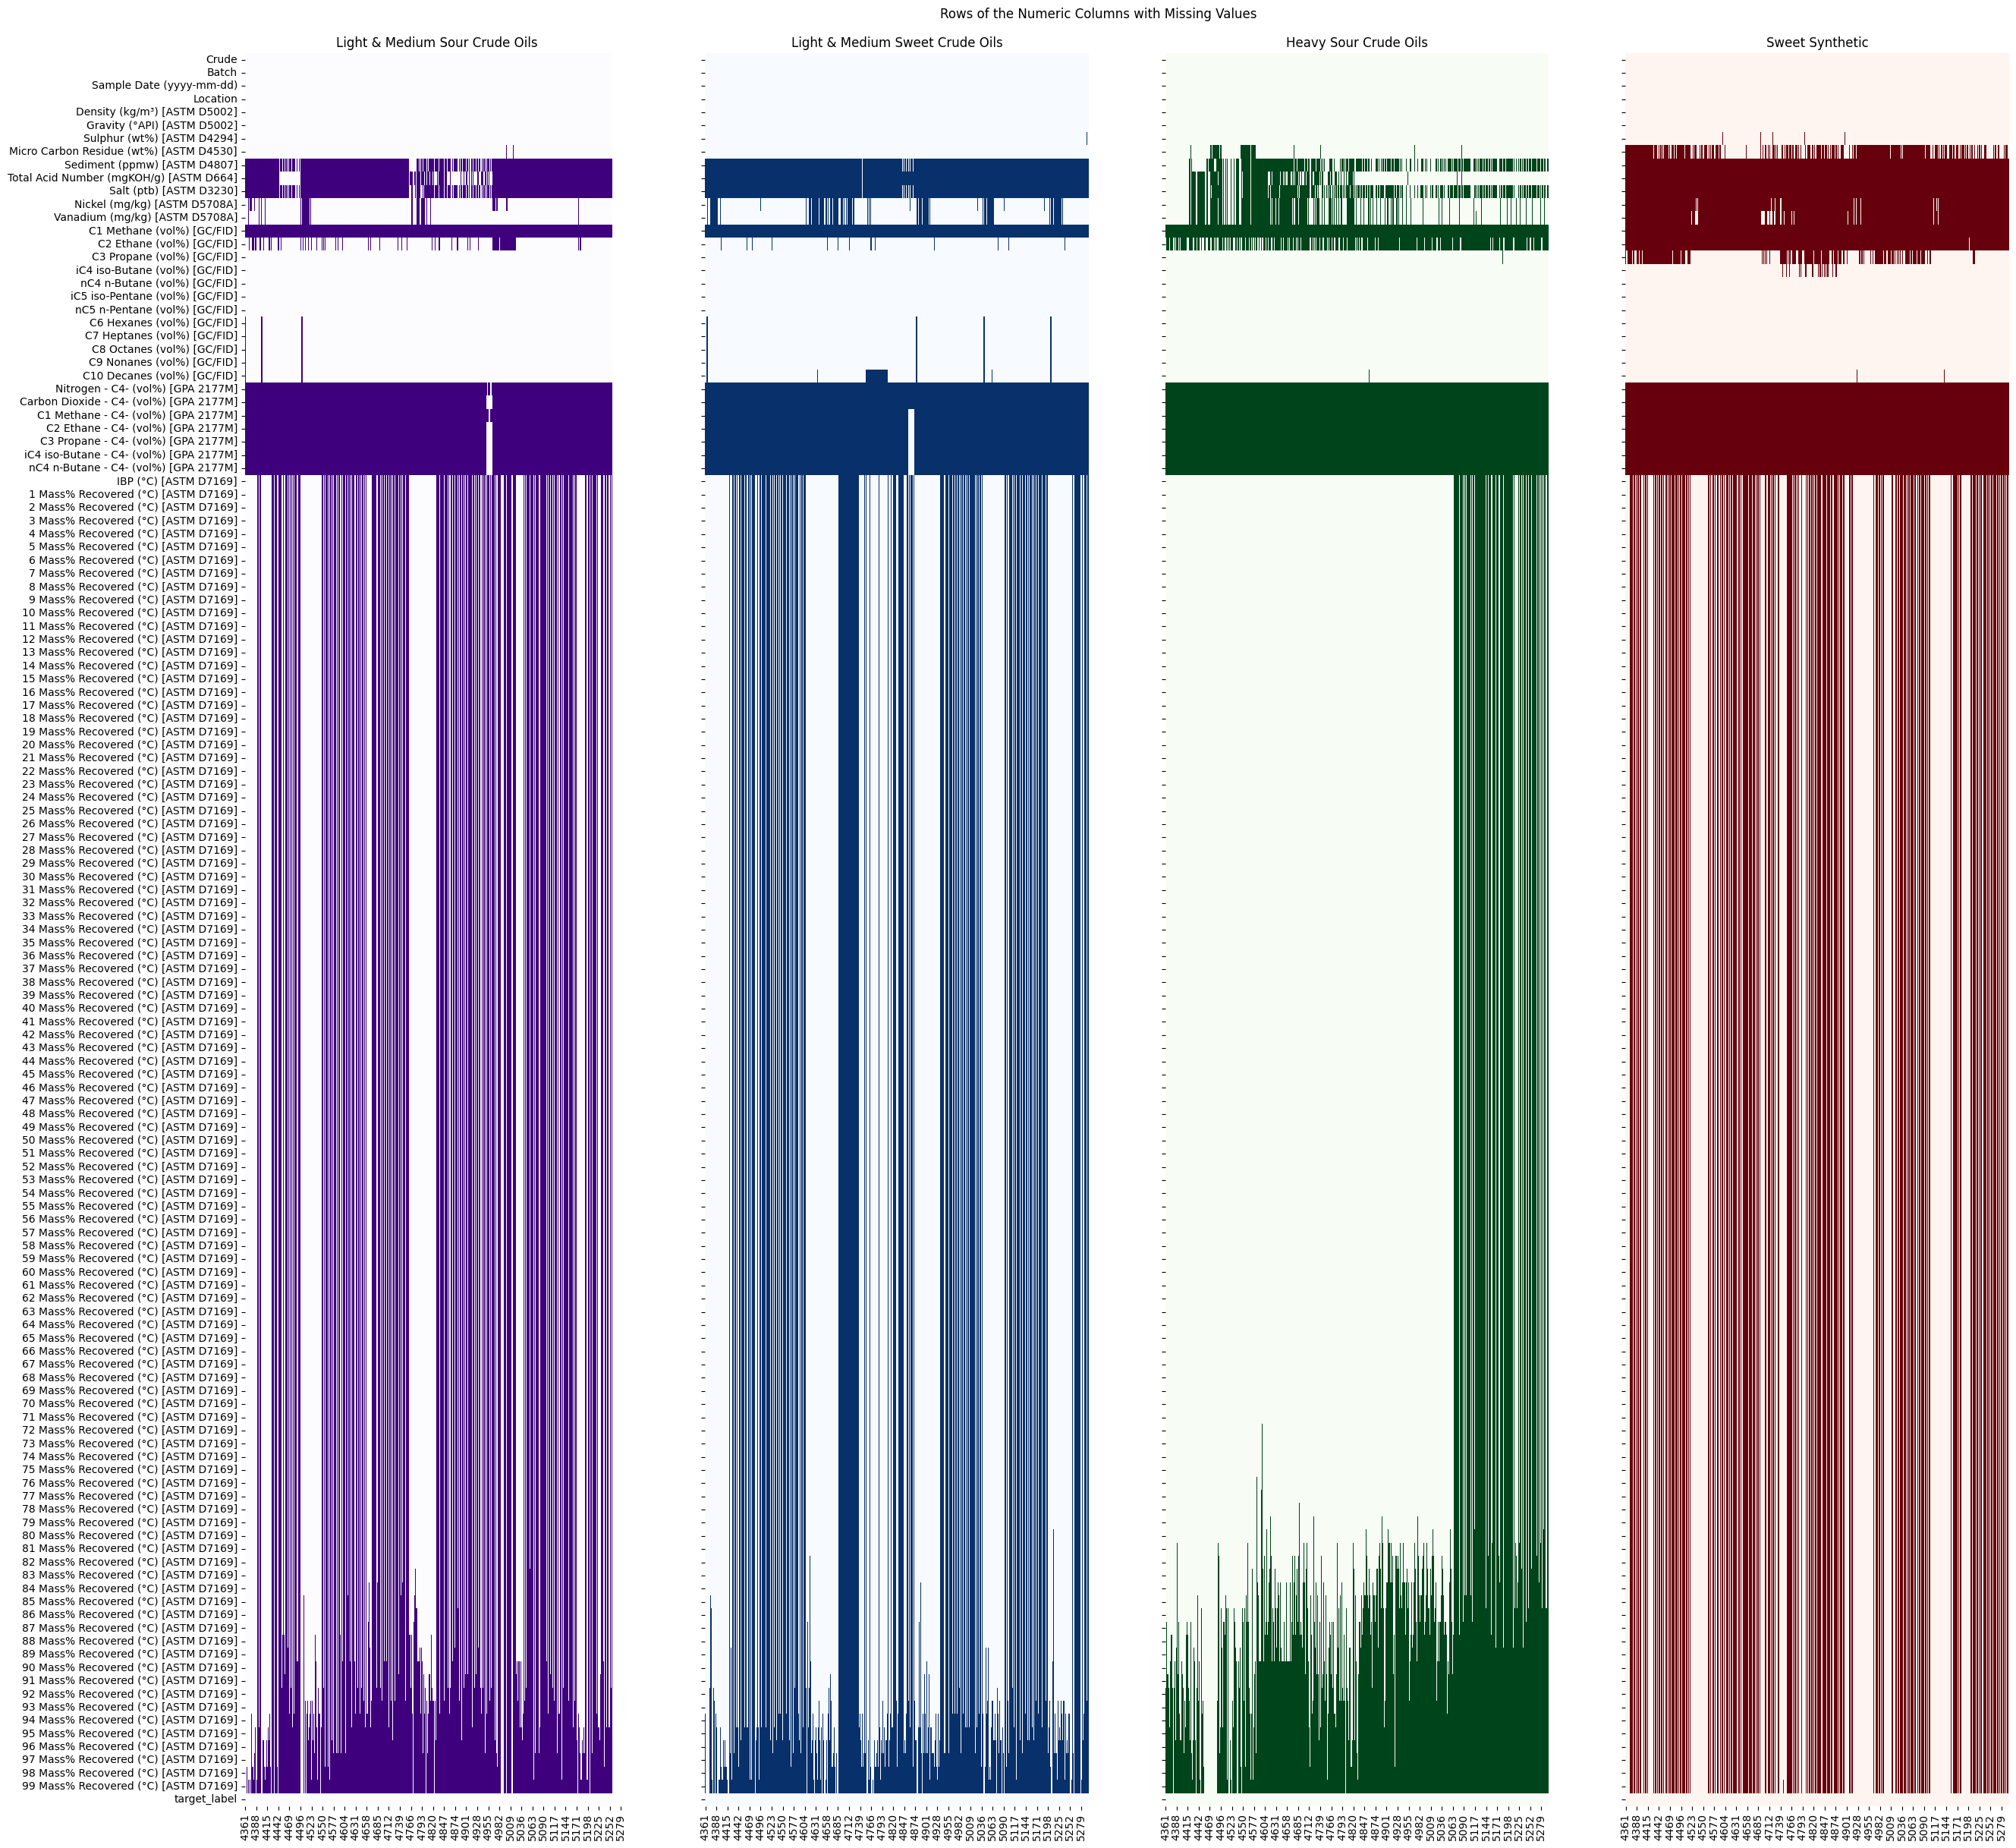

In [90]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(30,30), sharey=True, sharex=True)  
plt.suptitle('Rows of the Numeric Columns with Missing Values', y=0.9)

sns.heatmap(df[df['target_label']==0].T.isna(), cmap='Purples', cbar=False, ax=ax1)
sns.heatmap(df[df['target_label']==1].T.isna(), cmap='Blues', cbar=False, ax=ax2)
sns.heatmap(df[df['target_label']==2].T.isna(), cmap='Greens', cbar=False, ax=ax3)
sns.heatmap(df[df['target_label']==3].T.isna(), cmap='Reds', cbar=False, ax=ax4)

ax1.set_title('Light & Medium Sour Crude Oils')
ax2.set_title('Light & Medium Sweet Crude Oils')
ax3.set_title('Heavy Sour Crude Oils')
ax4.set_title('Sweet Synthetic')

plt.show()

### Dataset Info
- df.info() provides a concise summary of a DataFrame, including the:
    - Number of rows
    - Column names
    - Data types
- It also shows the count of non-null entries for each column, which makes it easy to identify missing values.
- In addition, it displays the memory usage of the DataFrame, helping to assess the size and efficiency of the dataset in memory.

In [ ]:
# Downcast floats and integer datatypes to minimize memory usage 
# for col in df.select_dtypes(include=['float64']).columns:
#     df[col] = pd.to_numeric(df[col], downcast='float') 
# for col in df.select_dtypes(include=['int64']).columns:
#     df[col] = pd.to_numeric(df[col], downcast='integer')

# Inspect column data types and size of the dataframe
# df.info()

### Dataset Metadata Summary
The table below provides the metadata of each column in our dataset:

In [ ]:
# Create a dataframe of the dataset metadata (as provided by the data source)



In [ ]:

# Display a markdown table of the metadata for each column
# display(Markdown(superconductor_metadata_df.to_markdown(index=False)))

> comments...

### Feature Descriptions
- The features are grouped into 8 general categories:  

Feature Group | Description
---|---
Atomic mass | 
FIE | 
Atomic radius | 
Density | 
Electron affinity | 
Fusion heat | 
Valence | 

# EDA

### Functions used for EDA

In [ ]:
# Function to plot a set of histograms for a subset of columns
def plot_column_histograms(subset):
    # Melt the numeric columns into one column
    df_melt = df[subset].melt(var_name='feature', value_name='value')

    # Create a base Altair histogram chart
    chart = alt.Chart(df_melt).mark_bar().encode(
        x = alt.X('value:Q', 
                axis=alt.Axis(title=''), 
                scale=alt.Scale(zero=False),
                bin=alt.Bin(maxbins=50)),
        y = alt.Y('count():Q', 
                axis=alt.Axis(title='')),
        # color = alt.Color('feature:N', legend=None)
    ).properties(
        width=175,
        height=150
    )

    # Display a histogram for each numeric_columns
    chart = alt.ConcatChart(
        concat=[
        chart.transform_filter(alt.datum.feature == value).properties(title=value)
        for value in subset
        ],
        columns=5
    ).configure_title(
        fontSize=10
    ).resolve_axis(
        x='independent',
        y='independent'
    ).resolve_scale(
        x='independent', 
        y='independent'
    )

    return chart

### Check for Missing Values
- This checks if any values are missing in the dataset

In [ ]:
df.isna().sum().sum()

### Define Column Groups
- These groups will be used for EDA purposes, and during the Pre-Processing stage

### Column Distributions & Descriptive Statistics
- Something about the distributions................
- The descriptive statistics summary gives us high level insights for each feature, including the:
  - Values counts
  - Mean
  - Standard Deviation
  - Minimum values
  - 25th, 50th, and 75th Quartiles
  - Maximum values
- These statistics can be used to get a general sense of the distribution of each numerical feature, and to possibly detect any numerical outliers.

> Column distribution observations here.........

### Column Correlations
- We need to check if there exists strong correlations between the numeric features. If there are then we should consider dropping one or more of the correlated features from the dataset.
- To aid in this evaluation we will visualize the data using a heatmap, where values of `[-1,1]` indicate as strong correlation, and values close to `0` indicate a weak correlation.
  - Note: Only the correlation values between `[-1.0, -0.5]` and `[0.5, 1.0]` are colored in the heatmap in order to focus on the highly correlated variables.

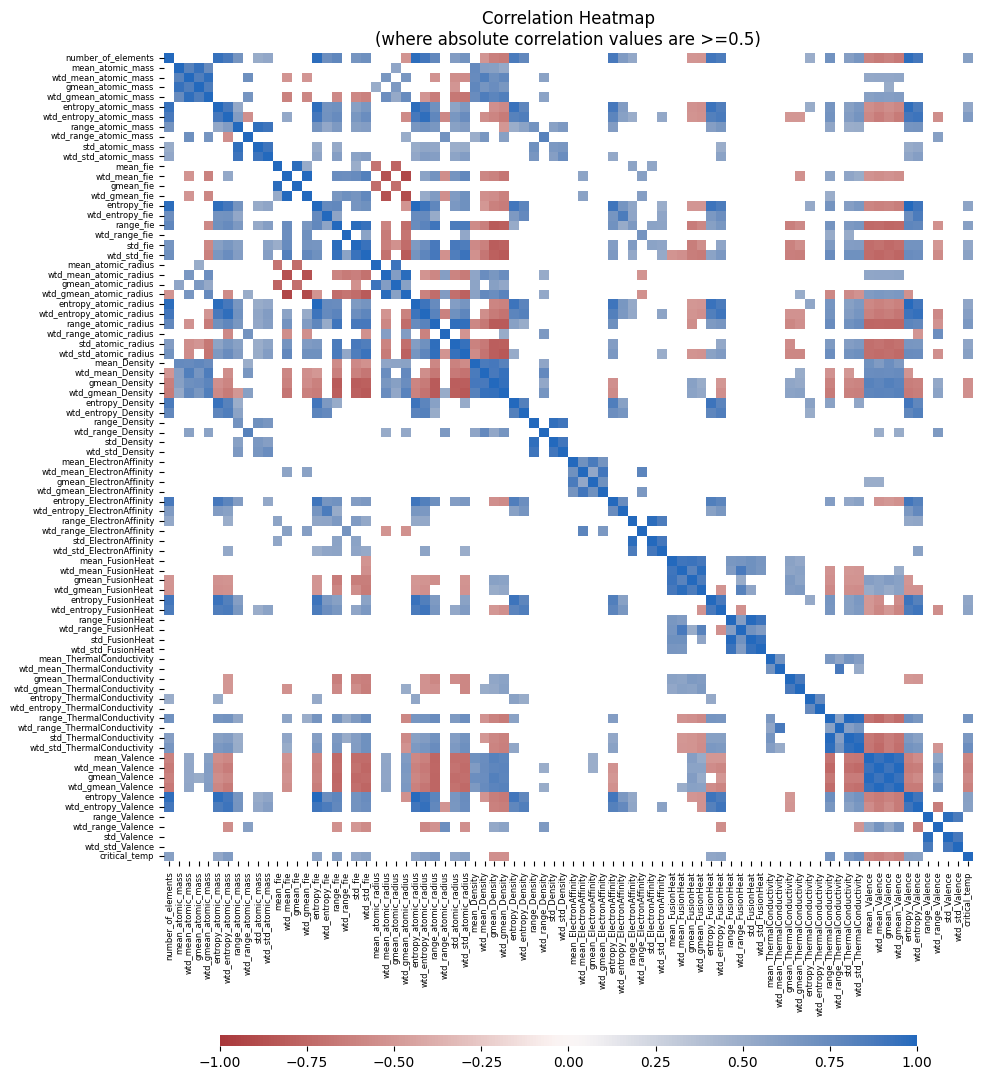

In [21]:
# Correlation Heatmap
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(
    df.corr(),
    cmap='vlag_r',
    mask=abs(df.corr())<=0.5, # Plot only absolute correlation values that are >=0.5
    square=True,
    vmin=-1, vmax=1,
    xticklabels=True, yticklabels=True,
    cbar_kws={'location':'bottom', 'aspect':60, 'shrink':0.6}
)
plt.xticks(fontsize=6) 
plt.yticks(fontsize=6) 
plt.title('Correlation Heatmap\n(where absolute correlation values are >=0.5)')
plt.show()

> Heatmap observations......

### EDA - Conclusions/Discussions/Next Steps:
- 

# Data Cleaning
fdsasdf

# Pre-Processing

### Data Scaling
- 

In [ ]:
numeric_transformer = SkPipeline([
    ('scaler', StandardScaler())
])

preprocessor_transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X)
    ],
    remainder='drop'
)

# Clustering

### Clustering Silhouette Scores
- Code below is a modified version based on an example given by sklearn (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([x/10 for x in range(-10,11,2)])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()